# Different Configuration using Homeostasis with Kmeans

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import matplotlib.pyplot as plt


from HOTS.Monitor import GenerateAM, DisplayAM
from HOTS.Event import Event, SimpleAlphabet
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer, FilterNHBD
from HOTS.Monitor import DisplayImage, DisplaySurface3D, DisplaySurface2D, DisplayConvergence
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansHomeoCluster import KmeansHomeo

# 1. Defining Common parameter

In [18]:
tau = 0.02
R = 2
nb_cluster = [4,8,16]
ImageSize = (32,32)
DataPath = '../Data/ExtractedStabilized.mat'
LabelPath = '../Data/alphabet_label.pkl'

# 2. StepbyStep Training

In [19]:

image_list = [1, 32, 19, 22, 29]
event0 = Event(ImageSize=(32,32),OutOnePolarity=True)

event0.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=image_list)

## Layer1

SpTe_Layer1= STS(tau=tau, R=R,verbose=0)
Surface_Layer1 = SpTe_Layer1.create(event = event0,kernel='linear')
event_filtered1, filt = SpTe_Layer1.FilterRecent(event = event0, threshold=2)
ClusterLayer1 = KmeansHomeo(nb_cluster = nb_cluster[0], to_record=True, verbose=1)
Prototype1 = ClusterLayer1.fit(SpTe_Layer1,NbCycle=0.1)
event2,_ = ClusterLayer1.predict(Surface=SpTe_Layer1.Surface,event = event_filtered1)
## Layer2
SpTe_Layer2= STS(tau=10*tau, R=2*R,verbose=0)
Surface_Layer2 = SpTe_Layer2.create(event = event2,kernel='linear')
ClusterLayer2 = KmeansHomeo(nb_cluster = nb_cluster[1], to_record=True, verbose=1)
Prototype2 = ClusterLayer2.fit(SpTe_Layer2,NbCycle=0.2)
event3,_ = ClusterLayer2.predict(Surface=SpTe_Layer2.Surface,event = event2)

## Layer3
SpTe_Layer3= STS(tau=10*10*tau, R=2*2*R,verbose=0)
Surface_Layer3 = SpTe_Layer3.create(event = event3,kernel='linear')
ClusterLayer3 = KmeansHomeo(nb_cluster = nb_cluster[2], to_record=True, verbose=1)
Prototype3 = ClusterLayer3.fit(SpTe_Layer3,NbCycle=0.2)
event4,_ = ClusterLayer3.predict(Surface=SpTe_Layer3.Surface,event = event3)


0 / 7352
5000 / 7352
0 / 14704
5000 / 14704
10000 / 14704
0 / 14704
5000 / 14704
10000 / 14704


## Exp1 :  Homeo Kmeans + Linear Kernel + NoiseFilter(=2) +  One Polarity in Input 

In [4]:
save_exp = False
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(NbTrainingData=36, NbTestingData=40,
                                                        Path='../Data/ExtractedStabilized.mat',
                                                        LabelPath='../Data/alphabet_label.pkl',
                                                        ClusteringData=[1, 32, 19, 22, 29],
                                                        OutOnePolarity = True, verbose=0)
## Defining the network
L1 = ClusteringLayer(tau=tau, R=R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='linear')
L2 = ClusteringLayer(tau=10*tau, R=2*R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='linear')
L3 = ClusteringLayer(tau=10*10*tau, R=2*2*R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='linear')
Net = Network([L1,L2,L3])
#Net = Network([L1])#,L2,L3])

if save_exp == True :
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN,
                                                 record_each=1000, NbCycle=1.5)

    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, ClusterList=ClusterLayer)

    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, ClusterList=ClusterLayer)

    Classif0 = Classifier(event0_o_tr,event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)

    eucli,norma,battach,accu = Classif0.HistogramDistance()
    
    SaveObject([ClusterLayer,Classif0],'../Records/EXP_03_HomeoKmeans/Exp1_2017_10_18.pkl')
    
else : 
    ClusterLayer,Classif0 = LoadObject('../Records/EXP_03_HomeoKmeans/Exp1_2017_10_18.pkl')
    eucli,norma,battach,accu = Classif0.HistogramDistance()

Classification Accuracy : 
 Euclidian Norm 95.00% 
 Normalized Norm 92.50%             
 BattachaNorm 95.00%


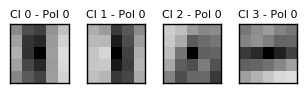

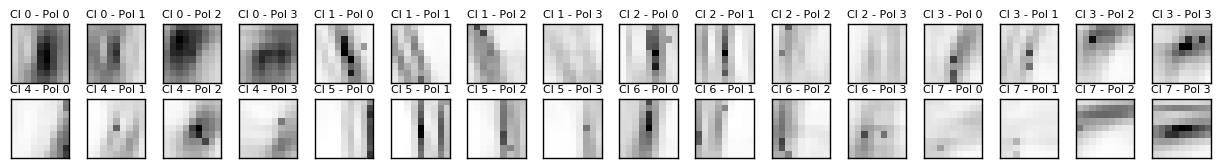

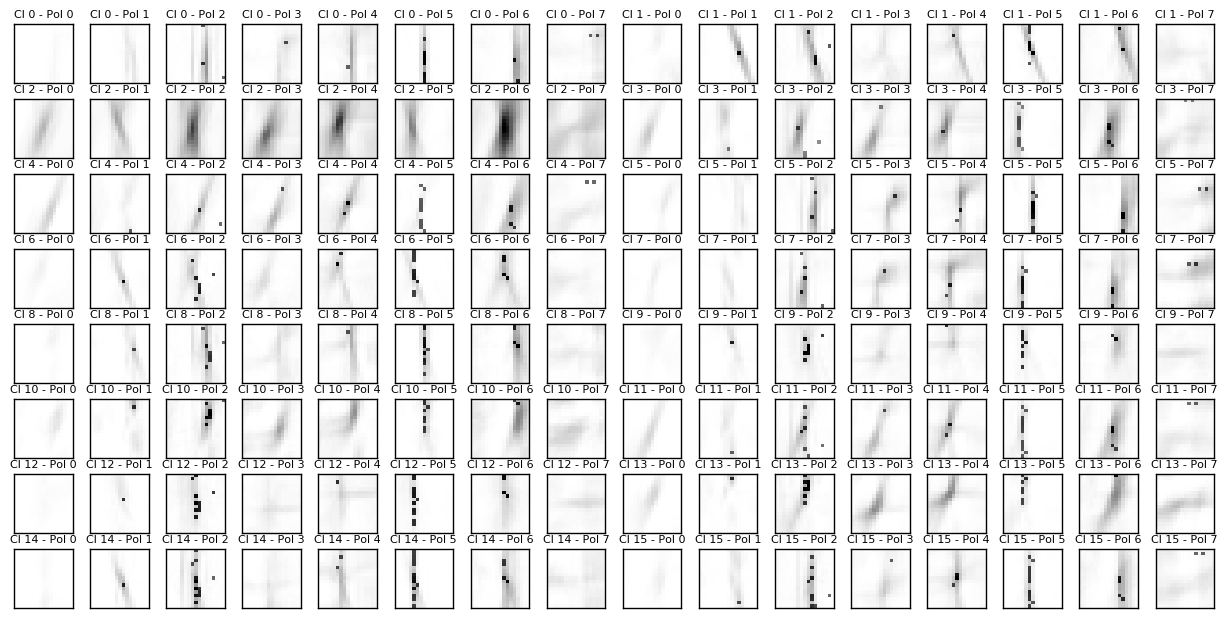

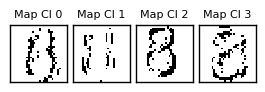

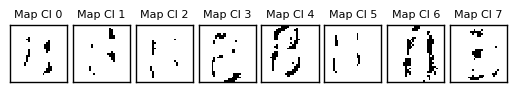

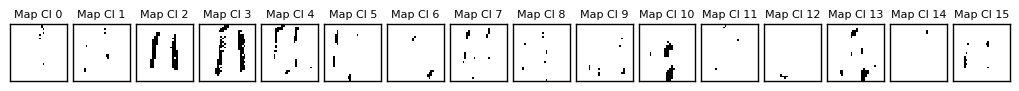

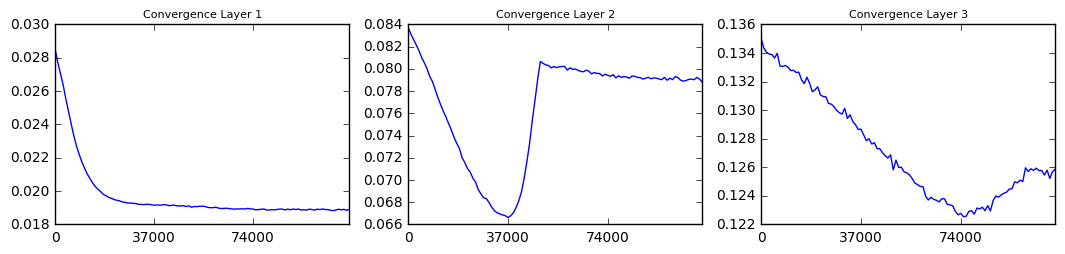

In [5]:
DisplaySurface2D(ClusterLayer[0].prototype,nb_polarities=1, scale=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4, scale=2)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8, scale=2)
event_to_show = Event(ImageSize=(32,32), ListPolarities=[-1,1],OutOnePolarity=True)
event_to_show.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=22)
Net.RunNetwork(event_to_show, ClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output,ClusterLayer[0],nb_image=0)
DisplayAM(mapL1,scale=2)
mapL2 = GenerateAM(Net.Layers[1].output,ClusterLayer[1],nb_image=0)
DisplayAM(mapL2,scale=2)
mapL3 = GenerateAM(Net.Layers[2].output,ClusterLayer[2],nb_image=0)
DisplayAM(mapL3,scale=2)

DisplayConvergence(ClusterLayer)

In [6]:
ClusterLayer[0].record['error'].values

array([ 0.02850217,  0.02770084,  0.02704108,  0.02635792,  0.02552735,
        0.02477236,  0.02402629,  0.02329747,  0.02268798,  0.02219399,
        0.02174308,  0.0213664 ,  0.02102806,  0.02074871,  0.02048938,
        0.02026976,  0.02011155,  0.01997233,  0.01980572,  0.01972697,
        0.01962351,  0.01957002,  0.01949948,  0.01945022,  0.01942327,
        0.01934852,  0.01933142,  0.01928959,  0.01928409,  0.01926655,
        0.01925743,  0.01921413,  0.01920187,  0.01919391,  0.01920038,
        0.01920828,  0.01917859,  0.01914983,  0.01917117,  0.01915967,
        0.01916979,  0.01919074,  0.0191478 ,  0.01912361,  0.01916786,
        0.01913704,  0.01910747,  0.01911169,  0.01912094,  0.01907406,
        0.01911365,  0.01903389,  0.0190745 ,  0.01907296,  0.01908746,
        0.0190933 ,  0.01908248,  0.01902198,  0.0190057 ,  0.01900363,
        0.01903133,  0.01898567,  0.01895241,  0.01895808,  0.01897416,
        0.01895373,  0.01893177,  0.01892085,  0.01893364,  0.01

## Exp2 :  Homeo Kmeans + Linear Kernel + NoiseFilter(=2) +  2 Polarity in Input 

In [7]:
save_exp = False
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(NbTrainingData=36, NbTestingData=40,
                                                        Path='../Data/ExtractedStabilized.mat',
                                                        LabelPath='../Data/alphabet_label.pkl',
                                                        ClusteringData=[1, 32, 19, 22, 29],
                                                        OutOnePolarity = False, verbose=0)
## Defining the network
L1 = ClusteringLayer(tau=tau, R=R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='linear')
L2 = ClusteringLayer(tau=10*tau, R=2*R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='linear')
L3 = ClusteringLayer(tau=10*10*tau, R=2*2*R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='linear')
Net = Network([L1,L2,L3])
#Net = Network([L1])#,L2,L3])

if save_exp == True :
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN,
                                                 record_each=1000, NbCycle=1.5)

    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, ClusterList=ClusterLayer)

    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, ClusterList=ClusterLayer)

    Classif0 = Classifier(event0_o_tr,event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)

    eucli,norma,battach,accu = Classif0.HistogramDistance()
    
    SaveObject([ClusterLayer,Classif0],'../Records/EXP_03_HomeoKmeans/Exp2_2017_10_18.pkl')
    
else : 
    ClusterLayer,Classif0 = LoadObject('../Records/EXP_03_HomeoKmeans/Exp2_2017_10_18.pkl')
    eucli,norma,battach,accu = Classif0.HistogramDistance()

Classification Accuracy : 
 Euclidian Norm 95.00% 
 Normalized Norm 92.50%             
 BattachaNorm 95.00%


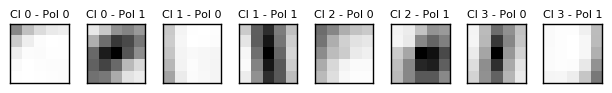

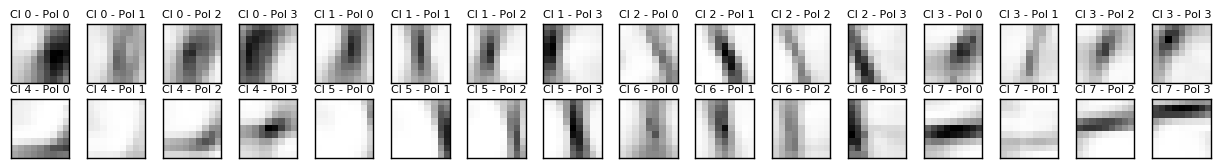

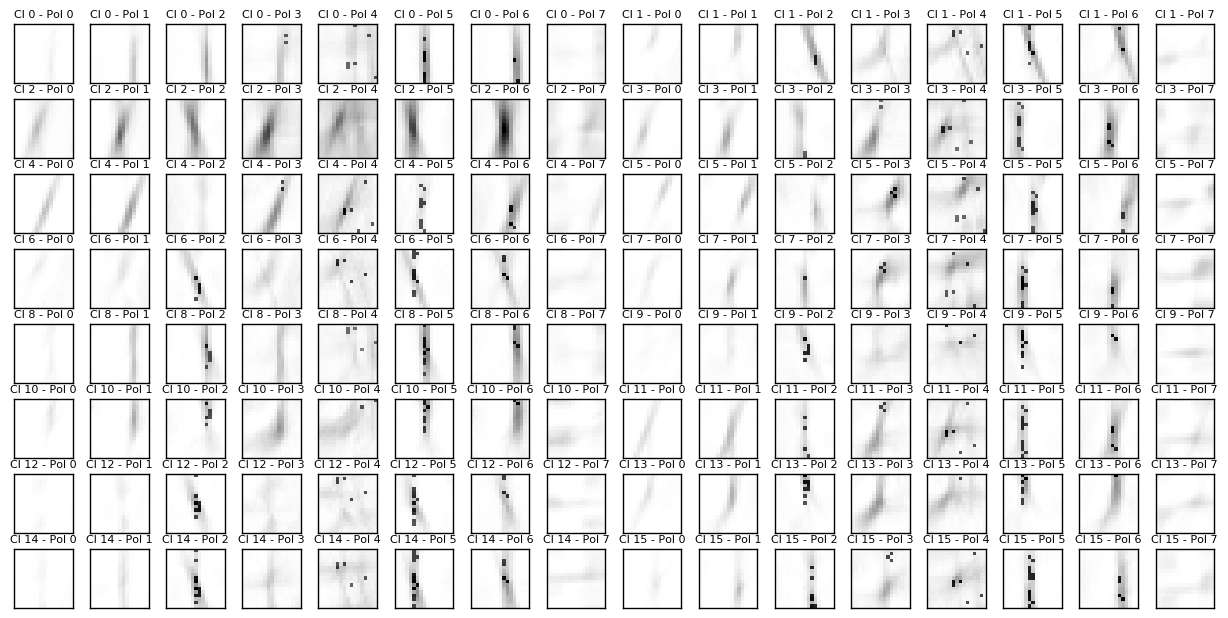

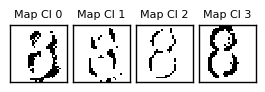

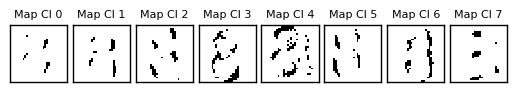

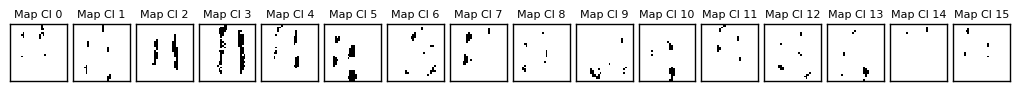

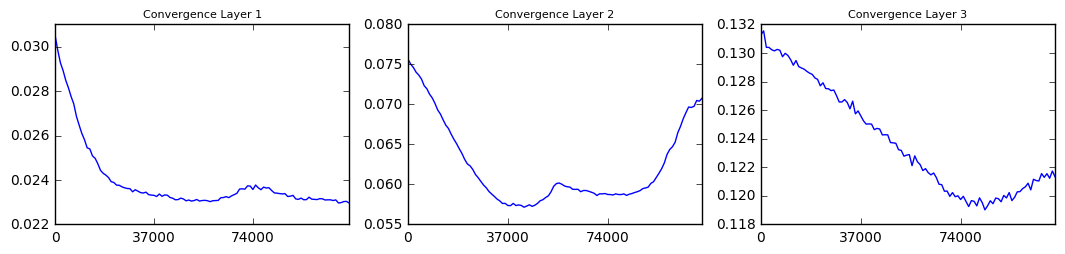

In [8]:
DisplaySurface2D(ClusterLayer[0].prototype,nb_polarities=2, scale=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4, scale=2)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8, scale=2)
event_to_show = Event(ImageSize=(32,32), ListPolarities=[-1,1],OutOnePolarity=False)
event_to_show.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=22)
Net.RunNetwork(event_to_show, ClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output,ClusterLayer[0],nb_image=0)
DisplayAM(mapL1,scale=2)
mapL2 = GenerateAM(Net.Layers[1].output,ClusterLayer[1],nb_image=0)
DisplayAM(mapL2,scale=2)
mapL3 = GenerateAM(Net.Layers[2].output,ClusterLayer[2],nb_image=0)
DisplayAM(mapL3,scale=2)

DisplayConvergence(ClusterLayer)


## Exp3 :  Homeo Kmeans + Exp Kernel + NoiseFilter(=2) +  1 Polarity in Input 

## Exp4 :  Homeo Kmeans + Exp Kernel + NoiseFilter(=2) +  2 Polarity in Input 

In [22]:
save_exp = False
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(NbTrainingData=36, NbTestingData=40,
                                                        Path='../Data/ExtractedStabilized.mat',
                                                        LabelPath='../Data/alphabet_label.pkl',
                                                        ClusteringData=[1, 32, 19, 22, 29],
                                                        OutOnePolarity = False, verbose=0)
## Defining the network
L1 = ClusteringLayer(tau=tau, R=R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='exponential')
L2 = ClusteringLayer(tau=10*tau, R=2*R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='exponential')
L3 = ClusteringLayer(tau=10*10*tau, R=2*2*R, verbose=0, ThrFilter=2, LearningAlgo='homeo',kernel='exponential')
Net = Network([L1,L2,L3])
#Net = Network([L1])#,L2,L3])

if save_exp == True :
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN,
                                                 record_each=1000, NbCycle=1.5)

    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, ClusterList=ClusterLayer)

    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, ClusterList=ClusterLayer)

    Classif0 = Classifier(event0_o_tr,event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)

    eucli,norma,battach,accu = Classif0.HistogramDistance()
    
    SaveObject([ClusterLayer,Classif0],'../Records/EXP_03_HomeoKmeans/Exp4_2017_10_18.pkl')
    
else : 
    ClusterLayer,Classif0 = LoadObject('../Records/EXP_03_HomeoKmeans/Exp4_2017_10_18.pkl')
    eucli,norma,battach,accu = Classif0.HistogramDistance()

Classification Accuracy : 
 Euclidian Norm 95.00% 
 Normalized Norm 92.50%             
 BattachaNorm 92.50%


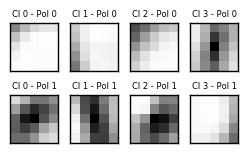

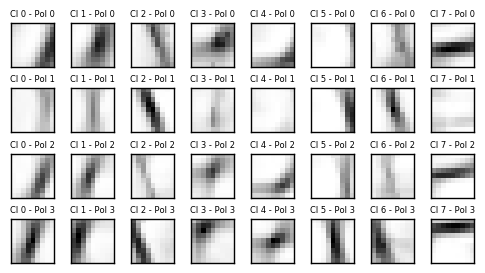

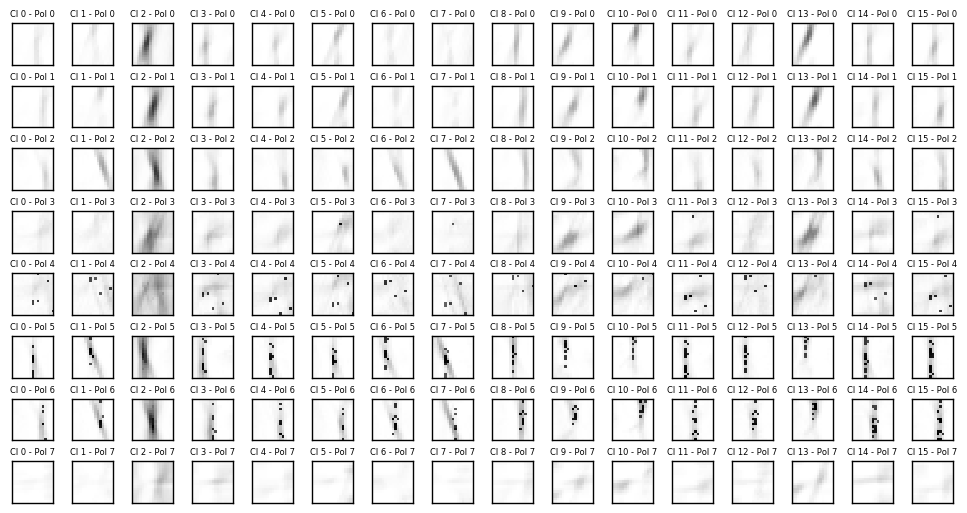

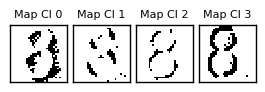

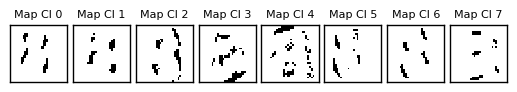

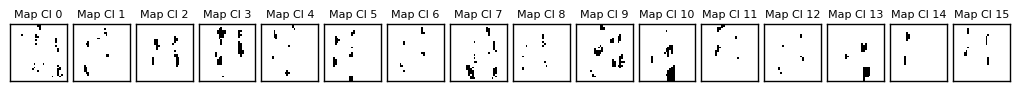

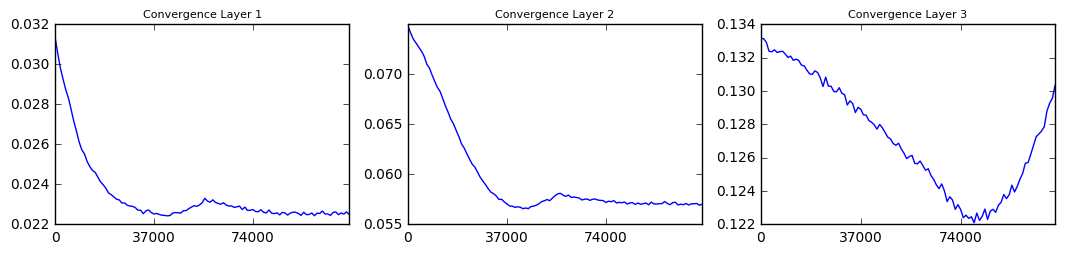

In [39]:
DisplaySurface2D(ClusterLayer[0].prototype,nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32,32), ListPolarities=[-1,1],OutOnePolarity=False)
event_to_show.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=22)
Net.RunNetwork(event_to_show, ClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output,ClusterLayer[0],nb_image=0)
DisplayAM(mapL1,scale=2)
mapL2 = GenerateAM(Net.Layers[1].output,ClusterLayer[1],nb_image=0)
DisplayAM(mapL2,scale=2)
mapL3 = GenerateAM(Net.Layers[2].output,ClusterLayer[2],nb_image=0)
DisplayAM(mapL3,scale=2)

DisplayConvergence(ClusterLayer)

In [21]:
Couche 1 : 2 filters 2 pol
Couche 2 : 8 filters (16) 2 pola
Couche 3 : 8 filters

SyntaxError: invalid syntax (<ipython-input-21-a5e878d7d804>, line 1)